In [14]:
import tensorflow as tf
import numpy as np
import sionna as sn

from sionna.phy.mapping import Mapper, Demapper
from sionna.phy.fec.ldpc import LDPC5GEncoder, LDPC5GDecoder
from sionna.phy.signal import Upsampling, Downsampling, RaisedCosineFilter
from sionna.phy.mapping import BinarySource
from sionna.phy.channel.tr38901 import TDL
from sionna.phy.channel import subcarrier_frequencies, cir_to_ofdm_channel, cir_to_time_channel, time_lag_discrete_time_channel, ApplyOFDMChannel, ApplyTimeChannel, OFDMChannel, TimeChannel
from sionna.phy.utils import ebnodb2no

In [27]:


# ============================================================
#            SC-FDE System with True Multipath
# ============================================================

class SCFDE_TDL(tf.keras.Model):

    def __init__(self,
                 num_bits=1024,
                 modulation_order=4,
                 upsample_factor=4,
                 rolloff=0.25,
                 tdl_model="A",
                 delay_spread=300e-9,
                 carrier_freq=3.5e9,
                 sampling_rate=15.36e6):
        """
        True SC-FDE using 3GPP TDL channel
        """

        super().__init__()

        self.num_bits = num_bits
        self.M = modulation_order
        self.sps = upsample_factor

        # ----------------------------------------------------
        # 1) Channel coding
        # ----------------------------------------------------
        self.encoder = LDPC5GEncoder(k=num_bits, n=2*num_bits)
        self.decoder = LDPC5GDecoder(self.encoder)

        # ----------------------------------------------------
        # 2) Mapping
        # ----------------------------------------------------
        self.mapper = Mapper("qam", self.M)
        self.demapper = Demapper("app", "qam", self.M)

        # # ----------------------------------------------------
        # # 4) Upsampling
        # # ----------------------------------------------------
        # self.upsampler = Upsampling(self.sps)
        # self.downsampler = Downsampling(self.sps)
        #
        # # ----------------------------------------------------
        # # 5 & 7) TX/RX filtering
        # # ----------------------------------------------------
        # self.tx_filter = RaisedCosineFilter(8, self.sps, rolloff)
        # self.rx_filter = RaisedCosineFilter(8, self.sps, rolloff)

        # ----------------------------------------------------
        # 6) TRUE multipath channel (TDL)
        # ----------------------------------------------------
        self.tdlchannel = TDL(model=tdl_model,
                           delay_spread=delay_spread,
                           carrier_frequency=carrier_freq,
                           min_speed=0.0)

        # ===== Determine CP from channel =====
        self.cp_length = 6  # Try to find the cp_length from TDL model

        self.sampling_rate = sampling_rate

        self.ebno_db = 40



        # print(f"Selected CP length: {self.cp_length}")

    # --------------------------------------------------------
    def add_cp(self, x):
        cp = x[:, -self.cp_length:]
        return tf.concat([cp, x], axis=1)

    def remove_cp(self, x):
        return x[:, self.cp_length:]

    # --------------------------------------------------------
    # MMSE-FDE
    # --------------------------------------------------------
    def mmse_fde(self, Y, H, snr_db):

        snr_lin = tf.pow(10.0, snr_db/10.0)
        Hc = tf.math.conj(H)

        return (Hc / (tf.abs(H)**2 + 1/snr_lin)) * Y

    # --------------------------------------------------------
    def call(self, batch_size=1, snr_db=10.0):

        # ================= TRANSMITTER =================
        no = ebnodb2no(self.ebno_db, self.M, 1/2)

        source = BinarySource()
        bits = source([batch_size, self.num_bits])

        # 1) Coding
        coded = self.encoder(bits)

        # 2) Mapping
        symbols = self.mapper(coded)

        # 3) CP addition
        x_time = self.add_cp(symbols)

        # # 4) Upsampling
        # tx_up = self.upsampler(tx_cp)
        #
        # # 5) TX filter
        # tx = self.tx_filter(tx_up)
        l_min, l_max = time_lag_discrete_time_channel(rg.bandwidth)
        l_tot = l_max-l_min+1

        cir = self.tdlchannel(batch_size, rg.num_time_samples+l_tot-1, rg.bandwidth)

        # Compute the discrete-time channel impulse reponse
        h_time = cir_to_time_channel(rg.bandwidth, *cir, l_min, l_max, normalize=True)
        # Function that will apply the discrete-time channel impulse response to an input signal
        channel_time = ApplyTimeChannel(rg.num_time_samples, l_tot=l_tot, add_awgn=True)
        y_time = channel_time(x_time, h_time, no)
        # ================= CHANNEL =================

        # 6) Multipath TDL channel
        rx, h_time = self.channel([tx],100,self.sampling_rate)

        # ================= RECEIVER =================

        # # 7) RX filter
        # rx = self.rx_filter(rx)
        #
        # # 8) Downsampling
        # rx = self.downsampler(rx)



        # 9) Remove CP
        rx = self.remove_cp(rx)

        # ---------- FDE ----------

        # 10) FFT
        Y = tf.signal.fft(rx)

        # Channel freq response
        H = tf.signal.fft(h_time[:, 0, 0, :tf.shape(rx)[1]])

        # MMSE-FDE
        X_hat = self.mmse_fde(Y, H, snr_db)

        # IDFT
        x_hat = tf.signal.ifft(X_hat)

        # 11) Demapping
        llr = self.demapper([x_hat, snr_db])

        # 12) Decoding
        decoded = self.decoder(llr)

        return bits, decoded


In [28]:
system = SCFDE_TDL(
    tdl_model="A",
    delay_spread=300e-9
)

# bits, dec = system(batch_size=32, snr_db=12)

# ber = tf.reduce_mean(tf.cast(bits != dec, tf.float32))
# print("BER:", ber.numpy())


In [32]:
system()

KeyboardInterrupt: 

In [19]:
from sionna.phy.channel.tr38901 import  CDL, AntennaArray
from sionna.phy.ofdm import ResourceGrid
import matplotlib.pyplot as plt

In [20]:

num_ut_ant = 4
num_bs_ant = 8

In [21]:
num_streams_per_tx = num_ut_ant

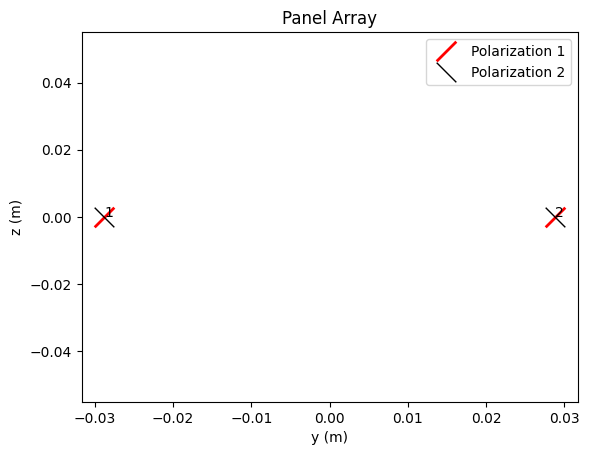

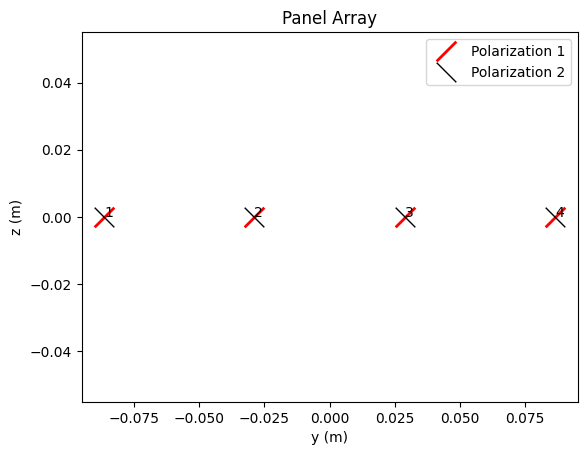

In [22]:
carrier_frequency = 2.6e9 # Carrier frequency in Hz.
                          # This is needed here to define the antenna element spacing.

ut_array = AntennaArray(num_rows=1,
                        num_cols=int(num_ut_ant/2),
                        polarization="dual",
                        polarization_type="cross",
                        antenna_pattern="38.901",
                        carrier_frequency=carrier_frequency)
ut_array.show()

bs_array = AntennaArray(num_rows=1,
                        num_cols=int(num_bs_ant/2),
                        polarization="dual",
                        polarization_type="cross",
                        antenna_pattern="38.901",
                        carrier_frequency=carrier_frequency)
bs_array.show()

In [23]:
delay_spread = 300e-9 # Nominal delay spread in [s]. Please see the CDL documentation
                      # about how to choose this value.

direction = "uplink"  # The `direction` determines if the UT or BS is transmitting.
                      # In the `uplink`, the UT is transmitting.
cdl_model = "B"       # Suitable values are ["A", "B", "C", "D", "E"]

speed = 10            # UT speed [m/s]. BSs are always assumed to be fixed.
                      # The direction of travel will chosen randomly within the x-y plane.

# Configure a channel impulse reponse (CIR) generator for the CDL model.
# cdl() will generate CIRs that can be converted to discrete time or discrete frequency.
cdl = CDL(cdl_model, delay_spread, carrier_frequency, ut_array, bs_array, direction, min_speed=speed)

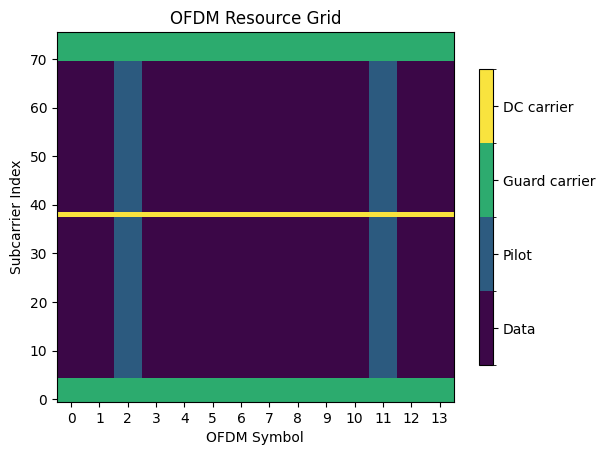

In [24]:
rg = ResourceGrid(num_ofdm_symbols=14,
                  fft_size=76,
                  subcarrier_spacing=15e3,
                  num_tx=1,
                  num_streams_per_tx=num_streams_per_tx,
                  cyclic_prefix_length=6,
                  num_guard_carriers=[5,6],
                  dc_null=True,
                  pilot_pattern="kronecker",
                  pilot_ofdm_symbol_indices=[2,11])
rg.show();

In [26]:
a, tau = cdl(batch_size=32, num_time_steps=rg.num_ofdm_symbols, sampling_frequency=1/rg.ofdm_symbol_duration)

In [30]:
print(rg.num_ofdm_symbols)

14


In [25]:
rg.bandwidth

1140000.0

In [26]:
15000*76

1140000

In [32]:
1/rg.ofdm_symbol_duration

13902.439024390244

In [27]:
print("Shape of the path gains: ", a.shape)
print("Shape of the delays:", tau.shape)

Shape of the path gains:  (32, 1, 8, 1, 4, 23, 14)
Shape of the delays: (32, 1, 1, 23)


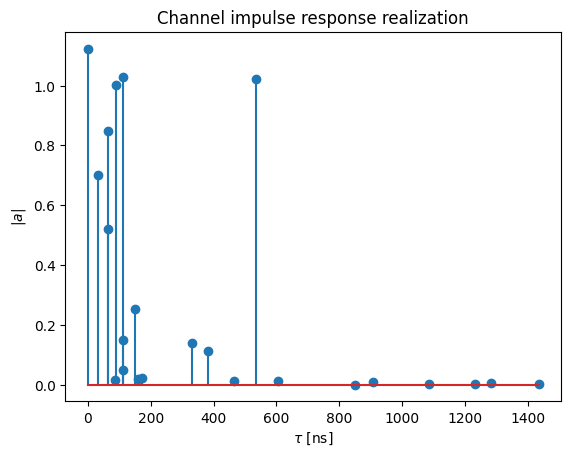

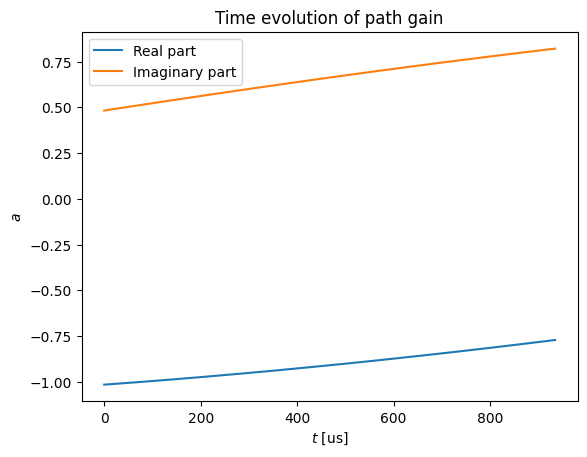

In [28]:
plt.figure()
plt.title("Channel impulse response realization")
plt.stem(tau[0,0,0,:]/1e-9, np.abs(a)[0,0,0,0,0,:,0])
plt.xlabel(r"$\tau$ [ns]")
plt.ylabel(r"$|a|$")


plt.figure()
plt.title("Time evolution of path gain")
plt.plot(np.arange(rg.num_ofdm_symbols)*rg.ofdm_symbol_duration/1e-6, np.real(a)[0,0,0,0,0,0,:])
plt.plot(np.arange(rg.num_ofdm_symbols)*rg.ofdm_symbol_duration/1e-6, np.imag(a)[0,0,0,0,0,0,:])
plt.legend(["Real part", "Imaginary part"])

plt.xlabel(r"$t$ [us]")
plt.ylabel(r"$a$");

In [29]:
np.arange(rg.num_ofdm_symbols)*rg.ofdm_symbol_duration/1e-6

array([  0.        ,  71.92982456, 143.85964912, 215.78947368,
       287.71929825, 359.64912281, 431.57894737, 503.50877193,
       575.43859649, 647.36842105, 719.29824561, 791.22807018,
       863.15789474, 935.0877193 ])